In [12]:
## Estimate of the electron temperature evolution heating by nanosecond lasers
##
## for low temperature and low density experiment (Te < 300 eV, ne/nc = 1e-2)
## neglecting the electron thermal diffusion
## accounting only for the inverse Bremsstrahlung laser absorption
##
## Equation:
## (3/2) n_e dT_e / dt = \nu_B I_0 / qe
##
## Parameters:
##     n_e   : number density of electron [cm^-3]
##     T_e0  : you need an initial value for T_e [eV]
##     \nu_B : bremsstrahlung laser absorption coefficient [cm^-1]
##     I_0   : laser intensity, usually assume a Gaussian time profile [W/cm^2]
##     qe    : elementry charge, [eV = J / 1.6e-19]

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# constants in CGS
c    = 3e10            # cm/s, light speed
qe   = 4.8e-10         # elementary charge
hbar = 1.0e-27         # Planck constant
me   = 9.1e-28         # electron mass, g

jetcmap = plt.get_cmap("jet", 9) #generate a jet map with 10 values "rainbow", "jet", YlOrRd
jet_vals = jetcmap(np.arange(9)) #extract those values as an array 
jet_vals[0] = [1.0, 1, 1.0, 1] #change the first value 
jet_vals[8] = [0.0, 0, 0.0, 1] #change the first value 
newcmap = mpl.colors.LinearSegmentedColormap.from_list("mine", jet_vals) 

from matplotlib import font_manager

font_dirs = ['/Users/yao/Documents/Calibri and Cambria Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Calibri'

plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)
plt.rc('legend', fontsize=12)

In [13]:
## for the ns-laser, we use 0.6 ns, 20 J, 2x0.5 mm (in ellipse) in 1w:
E_ts   = 110.0  # J
tau_ts = 5.0e-9  # s 
d_ts   = 0.1 # cm
S_ts   = np.pi * (d_ts/2.)**2 # cm^2
# S_ts   = np.pi* 2.0/2. * 0.5/2. * 1e-2 # cm^2
# S_ts   = 2e-3 * 300e-6 * 1e4  # cm^2, rectangular 2mm x 300um
I_ts   = E_ts / tau_ts / S_ts # W/cm2
# I_ts   = 3.8e13          # W/cm2,  Here I just took the parameter in the paper
print('Laser intensity for TS = {:.2e} W/cm2'.format(I_ts))


lmd_ts = 1.0*1e-4 # cm, 1 omega laser (1 um)
omg_ts = 2.*np.pi*c/lmd_ts
print('Laser angular frequency for TS = {:.2e} rad/s'.format(omg_ts))

Laser intensity for TS = 2.80e+12 W/cm2
Laser angular frequency for TS = 1.88e+15 rad/s


In [18]:
Te = [0.1]            # initial temperature
Te2 = [0.1]
Z0 = 1.               # material
fwhm = tau_ts         # equals to tau_ts above
ne = 2.0e17           # cm^-3

order = 4.            # order of gaussian profile
t_end = 10e-9        # estimation time
center = t_end / 2.0  # center of gaussian profile

omg_pe  = 5.64e4 * ne**0.5
print('plasma electron angular frequency = {:.2e} rad/s'.format(omg_pe))


# create the array for time evolution
num = 1000
time = np.linspace(0,t_end,num)
d_time = time[1] - time[0]


# Gaussian profile for the Laser time-evolution
def tgaussian(fwhm,order,center):
    import numpy as np
    sigma = (0.5*fwhm)**order/np.log(2.)
    return np.exp(-(time-center)**order / sigma)

def LMD1(temp):
    import numpy as np
    vte  = 4.19e7 * temp**0.5              # cm/s
    V_d1 = hbar/np.sqrt(me*temp*1.6e-12)   # cm, erg s / (g erg)^(1/2), erg -> g cm^2 s^-2, Note here eV -> erg by a factor of 1.6e-12
    V_d2 = Z0*qe**2 / (temp*1.6e-12)       # cm, qe -> m^1/2 l^3/2 / t, 
#     V    = np.maximum(omg_ts,omg_pe) * np.maximum(V_d1, V_d2)   # cm/s, from NRL (2019) P58 Eq.32
    V    = np.maximum(omg_ts,omg_pe) * V_d2 
    return np.log(vte/V)

def LMD2(temp):
    import numpy as np
    Ld = 7.43e2 * temp**0.5 * ne**(-0.5)  # cm
    ni = ne/Z0  # cm^-3
    Ri = ni**(-1./3.)  # cm
    vte  = 4.19e7 * temp**0.5              # cm/s
    bmax = np.minimum(np.maximum(Ld, Ri), vte/omg_ts)
    bmin = np.minimum(np.maximum(Z0*qe**2 / (temp*1.6e-12), hbar/np.sqrt(me*temp*1.6e-12)), Ri)  # bug from SI->CGS ???
    return np.log(1 + 0.7 * bmax/bmin)

# Inverse bremsstrahlung absorption coefficient for radiation of angular frequency 𝜔:
# Considered the temperature dependence
def nu_B(temp,coul_alog):
    return 3.1e-7 * Z0 * ne**2 * coul_alog(temp) * temp**(-1.5) * omg_ts**-2. * (1.-omg_pe**2/omg_ts**2)**(-0.5)   # cm^-1, how to get cm^-1 from this equation????

factor = 1.0
I_laser = factor*I_ts*tgaussian(fwhm,order,center)

# here's the integration, a typo in the formula (2 or e)?
for t in range(num): 
    dt = (nu_B(Te[t],LMD1)*I_laser[t]/1.5/ne)/1.6e-19 * d_time
    Te.append(Te[t]+dt)
    dt2 = (nu_B(Te2[t],LMD2)*I_laser[t]/1.5/ne)/1.6e-19 * d_time
    Te2.append(Te2[t]+dt2)

plasma electron angular frequency = 2.52e+13 rad/s


/var/folders/2t/97rc3fl92tg15k2l_4sk5hsh0000gn/T/ipykernel_75729/117669093.py:29: RuntimeWarning: invalid value encountered in scalar power
  vte  = 4.19e7 * temp**0.5              # cm/s
/var/folders/2t/97rc3fl92tg15k2l_4sk5hsh0000gn/T/ipykernel_75729/117669093.py:30: RuntimeWarning: invalid value encountered in sqrt
  V_d1 = hbar/np.sqrt(me*temp*1.6e-12)   # cm, erg s / (g erg)^(1/2), erg -> g cm^2 s^-2, Note here eV -> erg by a factor of 1.6e-12
/var/folders/2t/97rc3fl92tg15k2l_4sk5hsh0000gn/T/ipykernel_75729/117669093.py:49: RuntimeWarning: invalid value encountered in scalar power
  return 3.1e-7 * Z0 * ne**2 * coul_alog(temp) * temp**(-1.5) * omg_ts**-2. * (1.-omg_pe**2/omg_ts**2)**(-0.5)   # cm^-1, how to get cm^-1 from this equation????


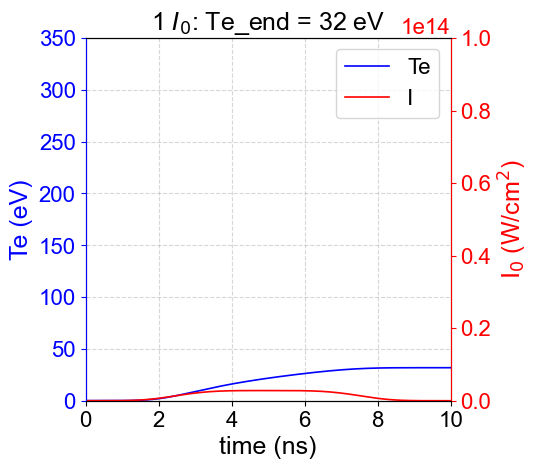

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 16#20
# mpl.rcParams['legend.fontname'] = 'Comic Sans MS'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['lines.linewidth'] = 1.2

width  = 3.14*1.5 # single column, 8cm
height = width
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# p1,  = ax1.plot(time*1e9,Te[:-1],'-b',label='Te, with LMD1')
p12, = ax1.plot(time*1e9,Te2[:-1],'-b',label='Te')
# p2,  = ax2.semilogy(time,I_laser,'-r',label='I')
p2,  = ax2.plot(time*1e9,I_laser,'-r',label='I')

lines = [p12, p2]
ax1.legend(lines, [l.get_label() for l in lines])
ax1.yaxis.label.set_color(p12.get_color())
ax2.yaxis.label.set_color(p2.get_color())

# ax1.spines["left"].set_edgecolor(p1.get_color())
ax2.spines["right"].set_edgecolor(p2.get_color())
ax2.spines["left"].set_edgecolor(p12.get_color())

ax1.set_xlabel('time (ns)')
ax1.set_ylabel('Te (eV)')
ax2.set_ylabel(r'I$_0$ (W/cm$^2$)')
ax2.set_ylim([0,100e12])
ax1.set_ylim([0,350])
# ax1.set_yticks([0,30,60,90,120,150])
# ax1.set_yticklabels([0,30,60,90,120,150])
ax1.set_xlim([0,10])
# ax1.set_xticklabels([-0.5, 0.0, 0.5, 1.0, 1.5, 2.0])
ax1.set_title('{:.0f} $I_0$: Te_end = {:.0f} eV'.format(factor,Te2[-1]),fontsize=18)

ax1.grid(linestyle='--',alpha=0.5)

ax1.tick_params(axis='y', colors=p12.get_color())
ax2.tick_params(axis='y', which='both', colors=p2.get_color())
# fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.set_size_inches(width, height)


In [20]:
Te[-1]

185.8258977867621

In [23]:
Te2[-1]

169.19443314042402

In [13]:
fig.savefig('/Users/yao/Desktop/'+'TS_heating_estimation'+'.png',bbox_inches='tight',dpi=300,transparent=True)

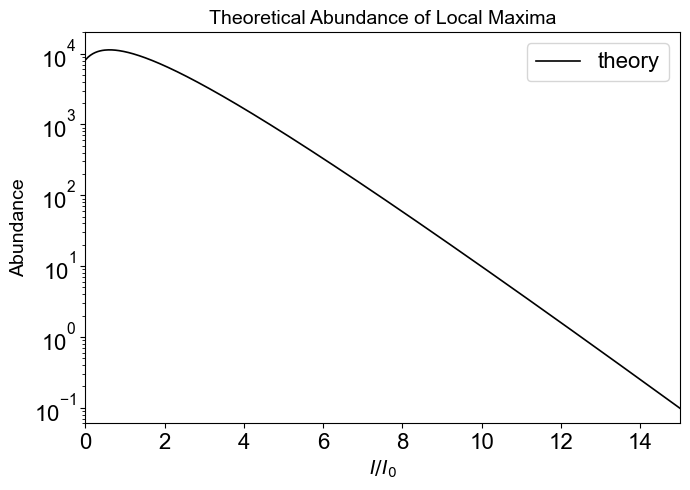

In [62]:
# Parameters from caption
rho_c = 0.005
S_abs = 1
det_Lambda_sqrt = rho_c**(-2)
I0 = 1  # since x = I / I0, we take I0=1 for normalized plot

# Define x range (I / I0)
x = np.linspace(0.01, 15, 500)  # Avoid 0 to prevent log scale issues

# Compute theoretical abundance M_u^A using Eq. (5)
prefactor = (4 * S_abs * det_Lambda_sqrt) / (np.pi**2 * I0)
abundance = prefactor * ((0.5 + (np.pi / 4)) * x + 0.5) * np.exp(-x)

# Plot
plt.figure(figsize=(7, 5))
plt.semilogy(x, abundance, label='theory', color='black')  # log scale on y-axis

plt.xlabel(r'$I/I_0$', fontsize=14)
plt.ylabel('Abundance', fontsize=14)
plt.title('Theoretical Abundance of Local Maxima', fontsize=14)
# plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.xlim([0, 15])
plt.ylim([6e-2, 2e4])
plt.tight_layout()
plt.savefig("/Users/yao/Desktop/theory_abundance.png", dpi=300, transparent=True)

# plt.show()

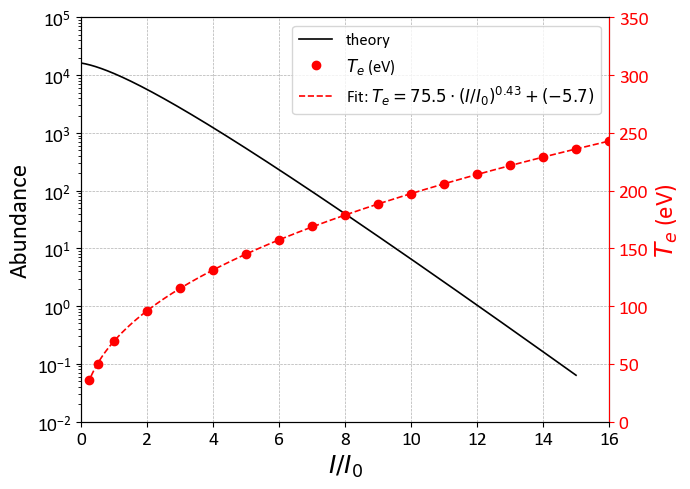

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
rho_c = 0.005
S_abs = 1
det_Lambda_sqrt = rho_c**(-2)
I0 = 1  # normalization factor

# x = I/I0
x = np.linspace(0.01, 15, 500)

# Theoretical abundance (solid line)
prefactor = (4 * S_abs * det_Lambda_sqrt) / (np.pi**2 * I0)
abundance = prefactor * ((0.5 + (np.pi / 4) * x + 0.5) * np.exp(-x))

# Electron temperature data
x_te = np.array([0.25, 0.5] + list(np.arange(1, 17)))
Te = np.array([36, 50, 70, 96, 116, 131, 145, 157, 169, 179, 188, 197, 206, 214, 222, 229, 236, 243])

# Define fitting function (power law + offset)
def fit_func(I, a, b, c):
    return a * (I ** b) + c

# Fit the curve
popt, pcov = curve_fit(fit_func, x_te, Te, p0=[70, 0.5, 0])  # initial guess

# Generate fitted curve
x_fit = np.linspace(0.2, 16, 500)
Te_fit = fit_func(x_fit, *popt)

# Plot
fig, ax1 = plt.subplots(figsize=(7, 5))

# Plot theoretical abundance (left y-axis)
line1, = ax1.semilogy(x, abundance, label='theory', color='black')
ax1.set_xlabel(r'$I/I_0$', fontsize=18)
ax1.set_ylabel('Abundance', fontsize=18)
ax1.grid(True, which="major", ls="--", lw=0.5)
ax1.legend(loc='upper right')
ax1.set_xlim([0, 16])
ax1.set_ylim([1e-2, 1e5])

# Secondary y-axis for electron temperature
ax2 = ax1.twinx()
line2 = ax2.plot(x_te, Te, 'ro', label=r'$T_e$ (eV)')
line3 = ax2.plot(x_fit, Te_fit, 'r--', label=fr'Fit: $T_e = {popt[0]:.1f} \cdot (I/I_0)^{{{popt[1]:.2f}}} + ({popt[2]:.1f})$')
ax2.set_ylabel(r'$T_e$ (eV)', fontsize=18, color='red')
# ax2.tick_params(axis='y', labelcolor='red', color='red')  # both label and ticks in red
ax2.tick_params(axis='y', labelcolor='red',color='red')
ax2.spines['right'].set_color('red')
ax2.set_ylim([0, 350])

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Save with transparent background
plt.tight_layout()
plt.savefig("abundance_with_Te.pdf", dpi=300, transparent=True)
plt.show()

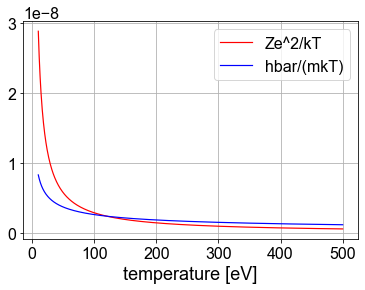

In [30]:
Z0   = 2
qe   = 4.8e-10         # CGS
hbar = 1.0e-27         # Planck constant
me   = 9.1e-28         # electron mass, g

temp = np.linspace(10,500,1000)
V_d1 = hbar/np.sqrt(me*temp*1.6e-12)   # cm, erg s / (g erg)^(1/2), erg -> g cm^2 s^-2, Note here eV -> erg by a factor of 1.6e-12
V_d2 = Z0*qe**2 / (temp*1.6e-12)       # cm, qe -> m^1/2 l^3/2 / t, 
plt.plot(temp, V_d2, '-r', label='Ze^2/kT')
plt.plot(temp, V_d1, '-b', label='hbar/(mkT)')
plt.xlabel('temperature [eV]')
plt.legend()
plt.grid()
plt.show()

Text(0, 0.5, 'nu_B [cm^-1 ?]')

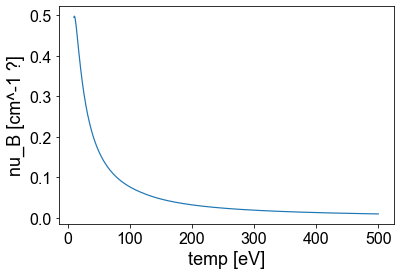

In [51]:
plt.plot(temp, nu_B(temp))
plt.xlabel('temp [eV]')
plt.ylabel('nu_B [cm^-1 ?]')

In [5]:
qe   = 4.8e-10         # CGS
hbar = 1.0e-27         # Planck constant
me   = 9.1e-28         # electron mass, g

ne   = 1e-2*1.0e21     # cm^-3,  in our case, 1e18
Te0  = 10              # eV,     in our case, ?
tau  = 600e-12         # s,      in our case, ?
I0   = 3.8e13          # W/cm2,  in our case, ?
Z0   = 1.0             # Hydrogen
# nu_B calculated separately below according to other parameters
c   = 3e10            # cm/s

omg_pe  = 5.64e4 * ne**0.5
print('plasma electron angular frequency = {:.2e} rad/s'.format(omg_pe))


plasma electron angular frequency = 1.78e+14 rad/s


In [31]:
## for \nu_B, in NRL:
# Te   = np.linspace(Te0,300,100)
Te0 = 100.
vte  = 4.19e7 * Te0**0.5   # cm/s
V    = np.maximum(omg_ts,omg_pe) * (hbar/np.sqrt(me*Te0))
nu_B = 3.1e-7 * Z0 * ne**2 * np.log(vte/V) * Te0**(-1.5) * omg_ts**-2. * (1.-omg_pe**2/omg_ts**2)**(-0.5)   # cm^-1
print(
'Inverse bremsstrahlung absorption coefficient \n \
for radiation of angular frequency {:.2e} rad/s \n \
at initial temperature Te0 = {:.1f} eV is {:.2e} cm^-1'.format(omg_ts,Te0, nu_B)
)

Inverse bremsstrahlung absorption coefficient 
 for radiation of angular frequency 1.88e+15 rad/s 
 at initial temperature Te0 = 100.0 eV is 1.03e+00 cm^-1
